In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output
from matplotlib import pyplot as plt

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import toxic_asset_attack
from model.amm.global_state import GlobalState

# same seed, same parameters = same simulation result[[
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 1,
    'shitcoin': 1
}

def lrna_price(asset: str):
    return price_dict['LRNA'] / price_dict[asset]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 1000000, 'LRNA_price': lrna_price('USD')},
                'shitcoin': {'liquidity': 10000, 'LRNA_price': lrna_price('shitcoin'), 'weight_cap': 0.1},
            },
            lrna_fee=0,
            asset_fee=0
        )
    },
    agents={
        'Attacker': Agent(
            holdings={'USD': 0, 'shitcoin': float('inf')},
            trade_strategy=toxic_asset_attack(
                pool_id='omnipool',
                asset_name='shitcoin',
                trade_size=10000
            )
        )
    },
    external_market=price_dict
)

runs = 25
time_steps = 400
trade_size_events = []
asset_price_events = []
weight_cap_events = []

trade_factor = 2000
for i in range(runs):
    clear_output(wait=True)
    print(f'Running simulation with trade size {trade_factor * (i + 1)}...  {int(i/runs * 100)}%')
    copy_state = initial_state.copy()
    copy_state.agents['Attacker'].trade_strategy = toxic_asset_attack(
        pool_id='omnipool', 
        asset_name='shitcoin',
        trade_size=trade_factor * (i + 1)
    )
    # print(copy_state)
    trade_size_events.append(run.run(copy_state, time_steps=time_steps, silent=True))
    
weight_factor = 0.91
for i in range(runs):
    clear_output(wait=True)
    copy_state = initial_state.copy()
    copy_state.pools['omnipool'].weight_cap['shitcoin'] *= weight_factor ** i
    copy_state.pools['omnipool'].weight_cap['shitcoin'] = round(copy_state.pools['omnipool'].weight_cap['shitcoin'], 4)
    
    print(f"Running simulation with weight cap {copy_state.pools['omnipool'].weight_cap['shitcoin']}...  {int(i/runs * 100)}%")

    # print(copy_state)
    weight_cap_events.append(run.run(copy_state, time_steps=time_steps, silent=True))
    
asset_price_factor = 1.5
for i in range(runs):
    clear_output(wait=True)
    copy_state = initial_state.copy()
    copy_state.external_market['shitcoin'] *= asset_price_factor ** i
    copy_state.external_market['shitcoin'] = round(copy_state.external_market['shitcoin'], 1)
    
    print(f"Running simulation with asset price {copy_state.external_market['shitcoin']}...  {int(i/runs * 100)}%")

    # print(copy_state)
    asset_price_events.append(run.run(copy_state, time_steps=time_steps, silent=True))

Running simulation with asset price 16834.1...  96%


In [2]:
%matplotlib inline

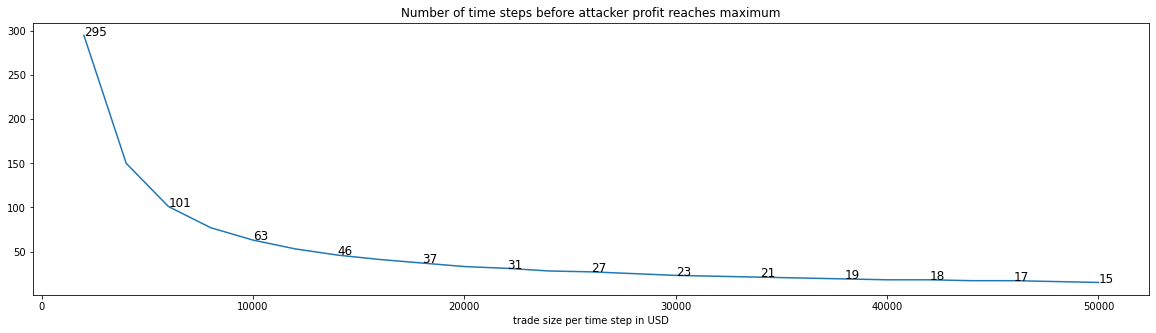

In [3]:
time_to_drain = []
for run in trade_size_events:
    end_state = run[-1]['state'].agents['Attacker'].holdings['USD']
    for n, event in enumerate(run):
        if event['state'].agents['Attacker'].holdings['USD'] == end_state:
            time_to_drain.append(n)
            break

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    [(1 + i) * trade_factor for i in range(runs)], 
    time_to_drain, 
)
plt.title('Number of time steps before attacker profit reaches maximum')
plt.xlabel('trade size per time step in USD')
points = list(range(runs))[::int(runs/10)]
# plt.scatter([trade_factor * (i + 1) for i in points], [time_to_drain[i] for i in points])
for i in points:
    plt.text(trade_factor * (i + 1), time_to_drain[i], time_to_drain[i], fontsize=12)

Text(0.5, 0, 'trade size per time step in USD')

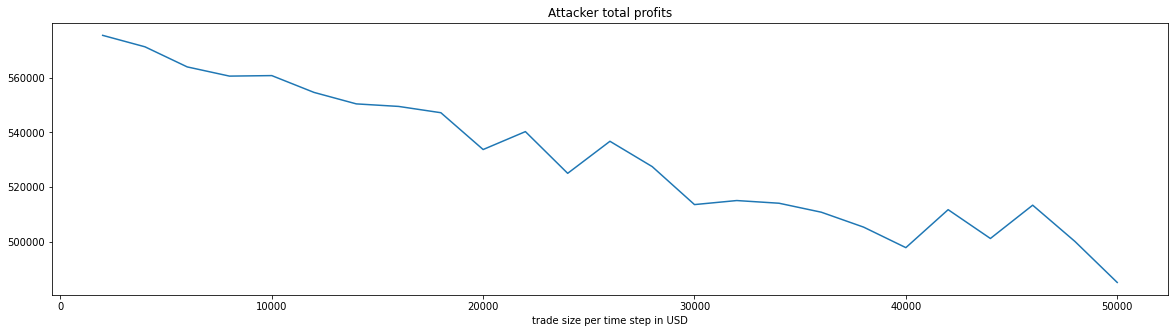

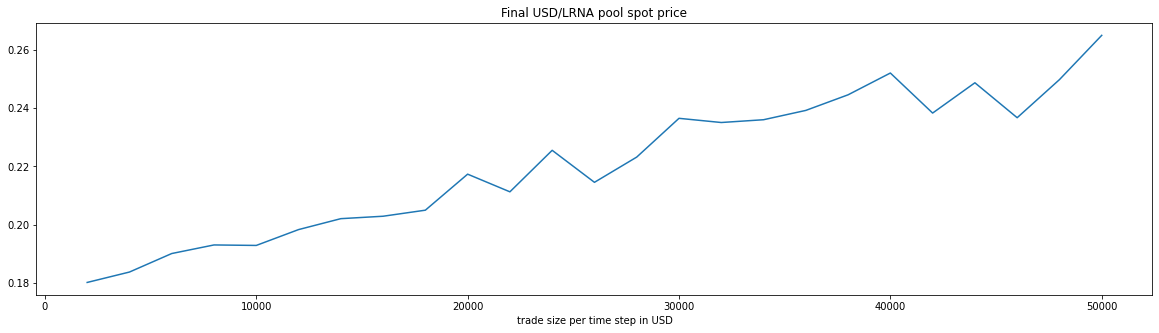

In [4]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    [(1 + i) * trade_factor for i in range(runs)], 
    [run[-1]['state'].agents['Attacker'].holdings['USD'] for run in trade_size_events], 
)
plt.title('Attacker total profits')
plt.xlabel('trade size per time step in USD')

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    [(1 + i) * trade_factor for i in range(runs)], 
    [1/run[-1]['state'].pools['omnipool'].lrna_price['USD'] for run in trade_size_events], 
)
plt.title('Final USD/LRNA pool spot price')
plt.xlabel('trade size per time step in USD')